In [1]:
import os
import zipfile
import cv2
import numpy as np

# Loading of Zip file and extraction
zip_file_path = 'E7-images.zip'

# Directory to extract images
extracted_images_dir = 'extracted_images'

# Create directory if it doesn't exist
if not os.path.exists(extracted_images_dir):
    os.makedirs(extracted_images_dir)

# Extract images from zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_images_dir)

# List all extracted image files
image_files = [f for f in os.listdir(extracted_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Initialize lists to store image arrays and filenames
image_arrays = []
grayscale_image_arrays = []
original_filenames = []

# Load and preprocess images
for image_file in image_files:
    # Construct full path to the image file
    image_path = os.path.join(extracted_images_dir, image_file)

    # Load image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        print(f"Unable to load image: {image_path}")
        continue

    # Convert image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Append grayscale image array to the list
    grayscale_image_arrays.append(grayscale_image)

    # Store the original filename
    original_filenames.append(image_file)

# Convert the list of grayscale image arrays to a NumPy array
grayscale_image_arrays_np = np.array(grayscale_image_arrays)

# Print the shape of the NumPy array
print("Shape of grayscale image array:", grayscale_image_arrays_np.shape)

# Function to create a new zip file containing preprocessed images
def create_preprocessed_zip(preprocessed_image_arrays, filenames, output_zip_path):
    # Create a new zip file
    with zipfile.ZipFile(output_zip_path, 'w') as zipf:
        # Loop through each preprocessed image array and its corresponding filename
        for filename, image_array in zip(filenames, preprocessed_image_arrays):
            # Convert image array back to uint8 if necessary
            if image_array.dtype != 'uint8':
                image_array = (image_array * 255).astype('uint8')

            # Write the image to the zip file with "p_" prefix
            image_filename = f"p_{filename}"
            cv2.imwrite(image_filename, image_array)
            zipf.write(image_filename)
            # Remove the temporary image file
            os.remove(image_filename)

# Path to save the new zip file
output_zip_path = 'preprocessed_images.zip'

# Call the function to create the new zip file containing preprocessed images
create_preprocessed_zip(grayscale_image_arrays_np, original_filenames, output_zip_path)

print(f"New zip file containing preprocessed images saved to: {output_zip_path}")


Shape of grayscale image array: (1183, 480, 640)
New zip file containing preprocessed images saved to: preprocessed_images.zip


In [2]:
import os
import zipfile
import cv2
import numpy as np

# Function to find minimum area bounding box around a contour
def min_area_rect(contour):
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    return box

# Path to the preprocessed ZIP file
preprocessed_zip_path = 'preprocessed_images.zip'

# Directory to extract images with bounding boxes
boxed_images_dir = 'boxed_images'

# Create directory if it doesn't exist
if not os.path.exists(boxed_images_dir):
    os.makedirs(boxed_images_dir)

# Extract images from the preprocessed ZIP file
with zipfile.ZipFile(preprocessed_zip_path, 'r') as zip_ref:
    zip_ref.extractall(boxed_images_dir)

# List all extracted preprocessed image files
image_files = [f for f in os.listdir(boxed_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Iterate through each image file to find contours and draw bounding boxes
for image_file in image_files:
    # Construct full path to the image file
    image_path = os.path.join(boxed_images_dir, image_file)

    # Load image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        print(f"Unable to load image: {image_path}")
        continue

    # Convert image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to create a mask
    _, mask = cv2.threshold(grayscale_image, 240, 255, cv2.THRESH_BINARY_INV)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate through each contour to draw bounding box on the original image
    for contour in contours:
        # Find minimum area bounding box
        box = min_area_rect(contour)

        # Draw bounding box on the original color image
        cv2.drawContours(image, [box], 0, (0, 255, 0), 2)

    # Save the original image with bounding box
    boxed_image_path = os.path.join(boxed_images_dir, f"boxed_{image_file}")
    cv2.imwrite(boxed_image_path, image)

# Rename the image files to start with "box_"
for image_file in image_files:
    old_path = os.path.join(boxed_images_dir, f"boxed_{image_file}")
    new_path = os.path.join(boxed_images_dir, f"box_{image_file}")
    os.rename(old_path, new_path)

# Path to save the new zip file with images containing bounding boxes
boxed_zip_path = 'box.zip'

# Create a new zip file containing images with bounding boxes
with zipfile.ZipFile(boxed_zip_path, 'w') as zipf:
    # Loop through each image file with bounding box
    for image_file in image_files:
        boxed_image_path = os.path.join(boxed_images_dir, f"box_{image_file}")
        zipf.write(boxed_image_path, f"box_{image_file}")

print(f"New zip file containing images with bounding boxes saved to: {boxed_zip_path}")


/tmp/ipykernel_123987/3102045609.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


New zip file containing images with bounding boxes saved to: box.zip


Cluster 1:


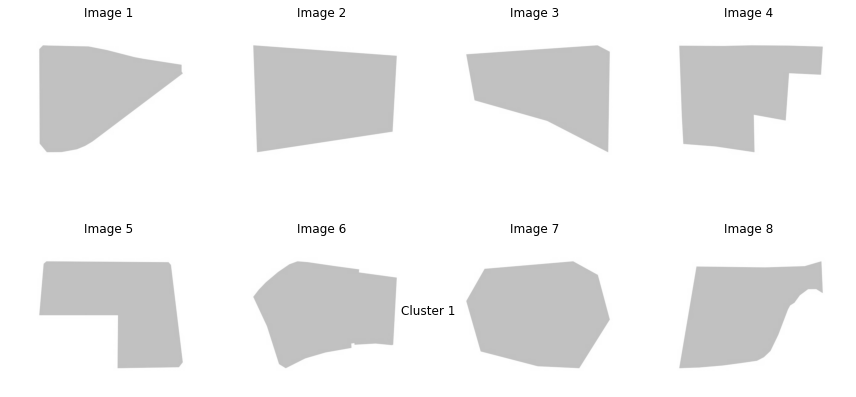

Cluster 2:


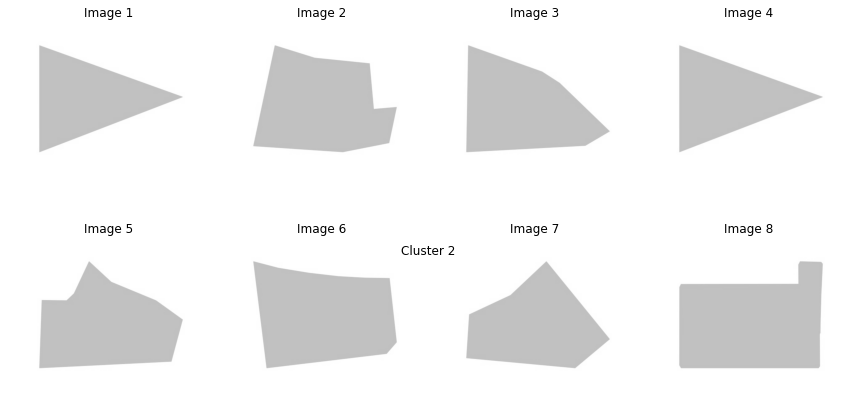

Cluster 3:


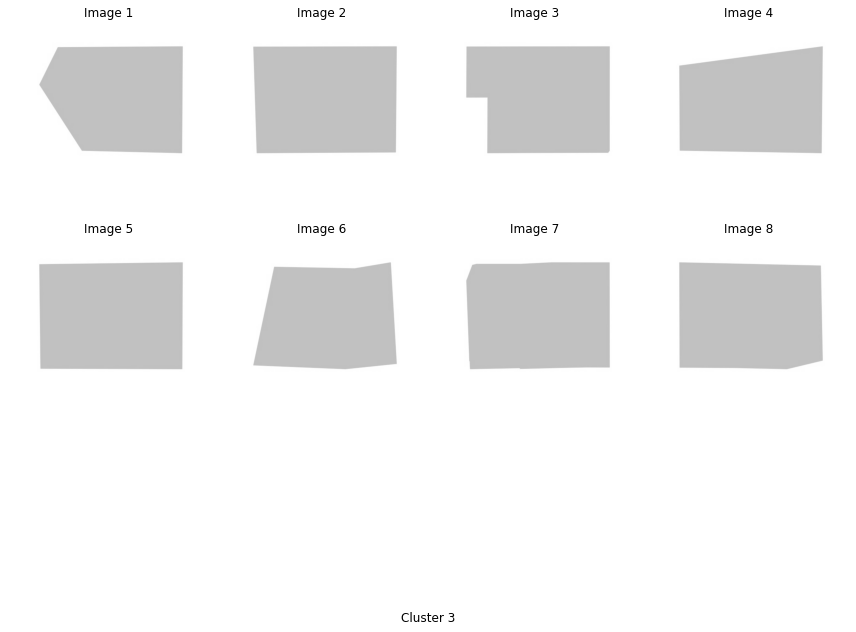

In [5]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from zipfile import ZipFile

# Define the path to the zip file and extraction directory
zip_file_path = 'preprocessed_images.zip'
extract_dir = 'preprocessed_images'

# Extract the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Function to load preprocessed images
def load_images(image_dir):
    images = []
    filenames = []
    
    # Iterate over each image file in the directory
    for filename in os.listdir(image_dir):
        # Read the image
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            continue
        
        # Flatten the grayscale image to create a feature vector
        feature_vector = image.flatten()
        
        # Append the feature vector and filename to the lists
        images.append(feature_vector)
        filenames.append(filename)
    
    return images, filenames

# Load preprocessed images
images, filenames = load_images(extract_dir)

# Convert list of images to NumPy array
X = np.array(images)

# Apply K-means clustering
n_clusters = 3  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Visualize 8 images from each cluster in a grid format
num_images_per_cluster = 8  # Number of images to display per cluster
num_cols = 4  # Number of columns for displaying images

for cluster_idx in range(n_clusters):
    print(f"Cluster {cluster_idx + 1}:")
    cluster_images = [filenames[i] for i, label in enumerate(labels) if label == cluster_idx]
    
    num_rows = int(np.ceil(len(cluster_images) / num_cols))
    
    plt.figure(figsize=(12, 3 * num_rows))
    
    for idx, image_filename in enumerate(cluster_images[:num_images_per_cluster]):
        image_path = os.path.join(extract_dir, image_filename)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.subplot(num_rows, num_cols, idx + 1)
        plt.imshow(image_rgb)
        plt.title(f"Image {idx + 1}")
        plt.axis('off')
    
    plt.suptitle(f"Cluster {cluster_idx + 1}")
    plt.tight_layout()
    plt.show()


In [6]:
import cv2
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile

# Define the path to the zip file and extraction directory
zip_file_path = 'preprocessed_images.zip'
extract_dir = 'preprocessed_images'

# Extract the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Function to process images and extract features
def process_images(image_dir):
    data = []
    
    # Iterate over each image file in the directory
    for filename in os.listdir(image_dir):
        # Read the image
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            continue
        
        # Threshold the image
        _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Find contours
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Calculate layout area
        layout_area = cv2.contourArea(contours[0]) if contours else 0.0
        
        # Calculate number of edges
        num_edges = len(contours[0]) if contours else 0
        
        # Calculate minimum bounding box dimensions
        if contours:
            rect = cv2.minAreaRect(contours[0])
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            
            width = np.linalg.norm(box[0] - box[1])
            height = np.linalg.norm(box[1] - box[2])
        else:
            width, height = 0.0, 0.0
        
        # Append data to list
        data.append([filename, layout_area, num_edges, width, height])
    
    return data

# Process images and extract features
data = process_images(extract_dir)

# Create a DataFrame
df = pd.DataFrame(data, columns=['Image Name', 'Layout Area', 'Number of Edges', 'Width', 'Height'])

# Save DataFrame to CSV file
csv_file_path = 'image_features.csv'
df.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")


/tmp/ipykernel_188034/674047984.py:44: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Data saved to image_features.csv


In [8]:
import cv2
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile

# Define the path to the zip file and extraction directory
zip_file_path = 'preprocessed_images.zip'
extract_dir = 'preprocessed_images'

# Extract the zip file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Function to process images and extract features
def process_images(image_dir):
    data = []
    
    # Iterate over each image file in the directory
    for filename in os.listdir(image_dir):
        # Read the image
        image_path = os.path.join(image_dir, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            continue
        
        # Apply Gaussian blur to smooth the image
        blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
        
        # Threshold the blurred image
        _, binary_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Find contours
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Initialize an empty list to store approximated contours
        approx_contours = []
        
        # Iterate over contours
        for contour in contours:
            # Approximate contour
            epsilon = 0.01 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            
            # Add approximated contour to list
            approx_contours.append(approx)
        
        # Calculate layout area
        layout_area = cv2.contourArea(approx_contours[0]) if approx_contours else 0.0
        
        # Calculate number of edges
        num_edges = len(approx_contours[0]) if approx_contours else 0
        
        # Calculate minimum bounding box dimensions
        if approx_contours:
            rect = cv2.minAreaRect(approx_contours[0])
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            
            width = np.linalg.norm(box[0] - box[1])
            height = np.linalg.norm(box[1] - box[2])
        else:
            width, height = 0.0, 0.0
        
        # Append data to list
        data.append([filename, layout_area, num_edges, width, height])
    
    # Sort data based on image names
    data.sort(key=lambda x: x[0])
    
    return data

# Process images and extract features
data = process_images(extract_dir)

# Create a DataFrame
df = pd.DataFrame(data, columns=['Image Name', 'Layout Area', 'Number of Edges', 'Width', 'Height'])

# Save DataFrame to CSV file
csv_file_path = 'image_features_.csv'
df.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")


/tmp/ipykernel_188034/1265810783.py:59: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


Data saved to image_features_.csv


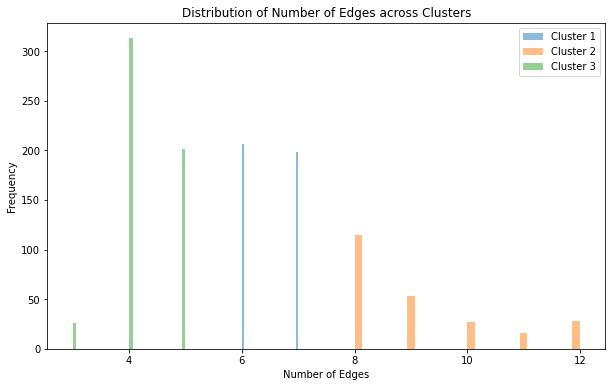

Clustered data saved to image_features_clustered.csv


In [9]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the data from the CSV file
csv_file_path = 'image_features_.csv'
df = pd.read_csv(csv_file_path)

# Select the 'Number of Edges' column for clustering
X = df[['Number of Edges']].values

# Apply K-means clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Visualize the clusters
plt.figure(figsize=(10, 6))
for cluster_idx in range(n_clusters):
    cluster_data = df[df['Cluster'] == cluster_idx]['Number of Edges']
    plt.hist(cluster_data, bins=30, alpha=0.5, label=f'Cluster {cluster_idx + 1}')

plt.title('Distribution of Number of Edges across Clusters')
plt.xlabel('Number of Edges')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Save the clustered data back to CSV file
clustered_csv_file_path = 'image_features_clustered.csv'
df.to_csv(clustered_csv_file_path, index=False)

print(f"Clustered data saved to {clustered_csv_file_path}")


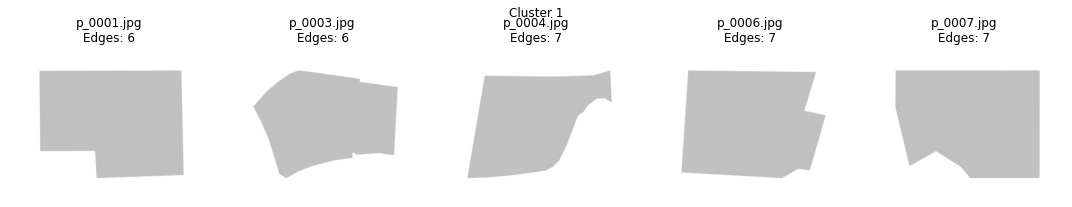

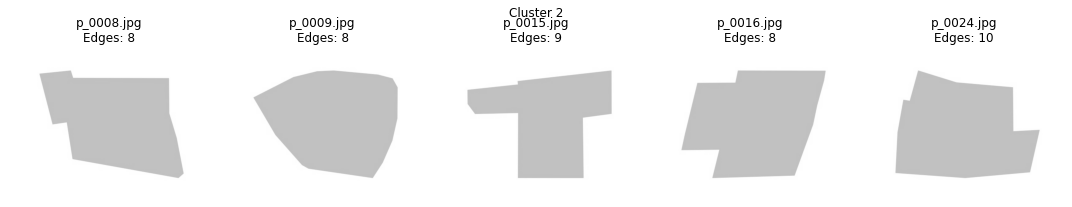

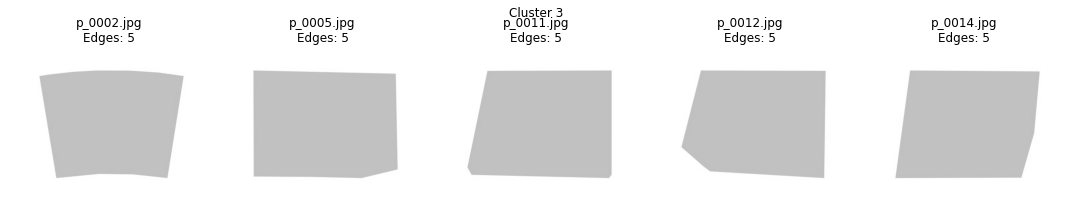

In [10]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Load the clustered data from the CSV file
clustered_csv_file_path = 'image_features_clustered.csv'
df = pd.read_csv(clustered_csv_file_path)

# Function to display images from each cluster
def display_images_from_cluster(df, cluster_idx, num_images=5):
    cluster_data = df[df['Cluster'] == cluster_idx]
    filenames = cluster_data['Image Name'].tolist()[:num_images]
    
    plt.figure(figsize=(15, 3))
    
    for idx, filename in enumerate(filenames):
        image_path = f"preprocessed_images/{filename}"
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, num_images, idx + 1)
        plt.imshow(image_rgb)
        plt.title(f"{filename}\nEdges: {cluster_data.iloc[idx]['Number of Edges']}")
        plt.axis('off')
    
    plt.suptitle(f"Cluster {cluster_idx + 1}")
    plt.tight_layout()
    plt.show()

# Display 5 images from each cluster
for cluster_idx in range(3):
    display_images_from_cluster(df, cluster_idx)


In [11]:
import cv2
import os
import pandas as pd

# Load the clustered data from the CSV file
clustered_csv_file_path = 'image_features_clustered.csv'
df = pd.read_csv(clustered_csv_file_path)

# Create separate folders for each cluster
for cluster_idx in range(3):
    folder_name = f'Cluster_{cluster_idx + 1}'
    os.makedirs(folder_name, exist_ok=True)

# Function to save images to their respective cluster folders
def save_images_to_cluster_folders(df):
    for _, row in df.iterrows():
        cluster_idx = row['Cluster']
        folder_name = f'Cluster_{cluster_idx + 1}'
        image_name = row['Image Name']
        
        source_path = f"preprocessed_images/{image_name}"
        destination_path = f"{folder_name}/{image_name}"
        
        # Copy image to the corresponding cluster folder
        os.system(f'cp "{source_path}" "{destination_path}"')

# Save images to their respective cluster folders
save_images_to_cluster_folders(df)

print("Images saved to their respective cluster folders.")


Images saved to their respective cluster folders.


In [12]:
import pandas as pd

# Load the clustered data from the CSV file
clustered_csv_file_path = 'image_features_clustered.csv'
df = pd.read_csv(clustered_csv_file_path)

# Function to map cluster index to cluster name
def map_cluster_name(cluster_idx):
    return f'Cluster_{cluster_idx + 1}'

# Add 'Cluster Name' column to the DataFrame
df['Cluster Name'] = df['Cluster'].apply(map_cluster_name)

# Save the updated DataFrame back to CSV file
updated_csv_file_path = 'image_features_clustered_updated.csv'
df.to_csv(updated_csv_file_path, index=False)

print(f"Updated data saved to {updated_csv_file_path}")



Updated data saved to image_features_clustered_updated.csv


In [34]:
import pandas as pd
import os

def find_similar_images(width, height, complexity_level, threshold=5):
    # Load CSV data
    df = pd.read_csv('image_features_clustered_updated.csv')
    
    # Map complexity level to cluster
    if complexity_level == 'High':
        cluster_folder = 'Cluster_2'  # Adjusted cluster value
        cluster_data = df[df['Cluster'] == 1]  # Adjusted cluster value
    elif complexity_level == 'Medium':
        cluster_folder = 'Cluster_1'  # Adjusted cluster value
        cluster_data = df[df['Cluster'] == 0]  # Adjusted cluster value
    elif complexity_level == 'Low':
        cluster_folder = 'Cluster_3'  # Adjusted cluster value
        cluster_data = df[df['Cluster'] == 2]  # Adjusted cluster value
    else:
        print("Invalid complexity level. Please choose from 'High', 'Medium', or 'Low'.")
        return
    
    # Calculate differences in dimensions
    diff_width = abs(cluster_data['Width'] - width)
    diff_height = abs(cluster_data['Height'] - height)
    
    # Find closest matches within threshold
    closest_matches = cluster_data[(diff_width <= threshold) & (diff_height <= threshold)]
    
    if closest_matches.empty:
        print(f"No similar images found within the specified threshold for {complexity_level} complexity.")
        return
    
    # Get the image names of the closest matches
    image_names = closest_matches['Image Name'].tolist()
    
    # Return full image paths
    image_paths = [os.path.join(cluster_folder, name) for name in image_names]
    
    # Check if all images belong to the correct cluster
    if not all(cluster_folder in path for path in image_paths):
        print(f"Error: Some images are not from the correct cluster ({cluster_folder}).")
        return
    
    return image_paths[:5]  # Return only the top 5 similar images

# User input
width = float(input("Enter the width of the tight-fitting box: "))
height = float(input("Enter the height of the tight-fitting box: "))
complexity_level = input("Enter the complexity level (High, Medium, Low): ")

# Find and print similar images
similar_images = find_similar_images(width, height, complexity_level)
if similar_images:
    print(f"Input values: Width = {width}, Height = {height}, Complexity Level = {complexity_level}")
    print(f"Top 5 similar image paths for {complexity_level} complexity:")
    for image_path in similar_images:
        print(image_path)


Input values: Width = 336.0, Height = 449.0, Complexity Level = High
Top 5 similar image paths for High complexity:
Cluster_2/p_0016.jpg
Cluster_2/p_0047.jpg
Cluster_2/p_0083.jpg
Cluster_2/p_0112.jpg
Cluster_2/p_0115.jpg


In [27]:
import pandas as pd
import os
from PIL import Image

def find_similar_images(width, height, complexity_level, threshold=5):
    # Load CSV data
    df = pd.read_csv('image_features_clustered_updated.csv')
    
    # Map complexity level to cluster
    if complexity_level == 'High':
        cluster_folder = 'Cluster_2'  # Adjusted cluster value
        cluster_data = df[df['Cluster'] == 1]  # Adjusted cluster value
    elif complexity_level == 'Medium':
        cluster_folder = 'Cluster_1'  # Adjusted cluster value
        cluster_data = df[df['Cluster'] == 0]  # Adjusted cluster value
    elif complexity_level == 'Low':
        cluster_folder = 'Cluster_3'  # Adjusted cluster value
        cluster_data = df[df['Cluster'] == 2]  # Adjusted cluster value
    else:
        print("Invalid complexity level. Please choose from 'High', 'Medium', or 'Low'.")
        return
    
    # Calculate differences in dimensions
    diff_width = abs(cluster_data['Width'] - width)
    diff_height = abs(cluster_data['Height'] - height)
    
    # Find closest matches within threshold
    closest_matches = cluster_data[(diff_width <= threshold) & (diff_height <= threshold)]
    
    if closest_matches.empty:
        print(f"No similar images found within the specified threshold for {complexity_level} complexity.")
        return
    
    # Get the image names of the closest matches
    image_names = closest_matches['Image Name'].tolist()
    
    # Return full image paths
    image_paths = [os.path.join(cluster_folder, name) for name in image_names]
    
    # Check if all images belong to the correct cluster
    if not all(cluster_folder in path for path in image_paths):
        print(f"Error: Some images are not from the correct cluster ({cluster_folder}).")
        return
    
    return image_paths[:5]  # Return only the top 5 similar images

# User input
width = float(input("Enter the width of the tight-fitting box: "))
height = float(input("Enter the height of the tight-fitting box: "))
complexity_level = input("Enter the complexity level (High, Medium, Low): ")

# Find and display similar images
similar_images = find_similar_images(width, height, complexity_level)
if similar_images:
    print(f"Input values: Width = {width}, Height = {height}, Complexity Level = {complexity_level}")
    print(f"Displaying top 5 similar images for {complexity_level} complexity:")
    for image_path in similar_images:
        img = Image.open(image_path)
        img.show()


Input values: Width = 336.0, Height = 449.0, Complexity Level = High
Displaying top 5 similar images for High complexity:


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/horizon/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/horizon/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/horizon/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/horizon/snap/code/common/.cache/gio-modules/libgiolibproxy.so


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/horizon/snap/code/common/.cache/gio-modules/libgiolibproxy.so
eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE
Failed to register: GDBus.Error:org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying
Failed to register: GDBus.Error:org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying
Failed to register: GDBus.Error:org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying
Failed to register: GDBus.Error:org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying


In [31]:
import pandas as pd
import os

def find_similar_images(width, height, complexity_level, threshold=5):
    # Load CSV data
    df = pd.read_csv('image_features_clustered_updated.csv')
    
    # Map complexity level to cluster
    if complexity_level == 'High':
        cluster_folder = 'Cluster_2'
        cluster_data = df[df['Cluster'] == 1]
    elif complexity_level == 'Medium':
        cluster_folder = 'Cluster_1'
        cluster_data = df[df['Cluster'] == 0]
    elif complexity_level == 'Low':
        cluster_folder = 'Cluster_3'
        cluster_data = df[df['Cluster'] == 2]
    else:
        print("Invalid complexity level. Please choose from 'High', 'Medium', or 'Low'.")
        return
    
    # Calculate differences in dimensions
    diff_width = abs(cluster_data['Width'] - width)
    diff_height = abs(cluster_data['Height'] - height)
    
    # Find closest matches within threshold
    closest_matches = cluster_data[(diff_width <= threshold) & (diff_height <= threshold)]
    
    if closest_matches.empty:
        print(f"No similar images found within the specified threshold for {complexity_level} complexity.")
        return
    
    # Get the image names of the closest matches
    image_names = closest_matches['Image Name'].tolist()
    
    # Return full image paths
    image_paths = [os.path.join(cluster_folder, name) for name in image_names]
    
    # Check if all images belong to the correct cluster
    if not all(cluster_folder in path for path in image_paths):
        print(f"Error: Some images are not from the correct cluster ({cluster_folder}).")
        return
    
    return image_paths[:5]  # Return only the top 5 similar images

# User input
width = float(input("Enter the width of the tight-fitting box: "))
height = float(input("Enter the height of the tight-fitting box: "))
complexity_level = input("Enter the complexity level (High, Medium, Low): ")

# Find similar images
similar_images = find_similar_images(width, height, complexity_level)
if similar_images:
    print(f"Input values: Width = {width}, Height = {height}, Complexity Level = {complexity_level}")
    print(f"Top 5 similar image paths for {complexity_level} complexity:")
    for image_path in similar_images:
        print(image_path)


No similar images found within the specified threshold for High complexity.


In [29]:
import pandas as pd
from PIL import Image
import os

def find_similar_images(width, height, complexity_level, threshold=5):
    # Load CSV data
    df = pd.read_csv('image_features_clustered_updated.csv')
    
    # Map complexity level to cluster
    if complexity_level == 'High':
        cluster_folder = 'Cluster_2'
        cluster_data = df[df['Cluster'] == 1]
    elif complexity_level == 'Medium':
        cluster_folder = 'Cluster_1'
        cluster_data = df[df['Cluster'] == 0]
    elif complexity_level == 'Low':
        cluster_folder = 'Cluster_3'
        cluster_data = df[df['Cluster'] == 2]
    else:
        print("Invalid complexity level. Please choose from 'High', 'Medium', or 'Low'.")
        return
    
    # Calculate differences in dimensions
    diff_width = abs(cluster_data['Width'] - width)
    diff_height = abs(cluster_data['Height'] - height)
    
    # Find closest matches within threshold
    closest_matches = cluster_data[(diff_width <= threshold) & (diff_height <= threshold)]
    
    if closest_matches.empty:
        print(f"No similar images found within the specified threshold for {complexity_level} complexity.")
        return
    
    # Get the image names of the closest matches
    image_names = closest_matches['Image Name'].tolist()
    
    # Return full image paths
    image_paths = [os.path.join(cluster_folder, name) for name in image_names]
    
    # Check if all images belong to the correct cluster
    if not all(cluster_folder in path for path in image_paths):
        print(f"Error: Some images are not from the correct cluster ({cluster_folder}).")
        return
    
    return image_paths[:5]  # Return only the top 5 similar images

# User input
width = float(input("Enter the width of the tight-fitting box: "))
height = float(input("Enter the height of the tight-fitting box: "))
complexity_level = input("Enter the complexity level (High, Medium, Low): ")

# Find similar images
similar_images = find_similar_images(width, height, complexity_level)
if similar_images:
    print(f"Input values: Width = {width}, Height = {height}, Complexity Level = {complexity_level}")
    print(f"Displaying top 5 similar images for {complexity_level} complexity:")
    for image_path in similar_images:
        try:
            img = Image.open(image_path)
            img.show()
        except Exception as e:
            print(f"Error opening {image_path}: {e}")


Input values: Width = 336.0, Height = 449.0, Complexity Level = High
Displaying top 5 similar images for High complexity:


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/horizon/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/horizon/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/horizon/snap/code/common/.cache/gio-modules/libgiolibproxy.so
/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/horizon/snap/code/common/.cache/gio-modules/libgiolibproxy.so


/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/horizon/snap/code/common/.cache/gio-modules/libgiolibproxy.so
eog: symbol lookup error: /snap/core20/current/lib/x86_64-linux-gnu/libpthread.so.0: undefined symbol: __libc_pthread_init, version GLIBC_PRIVATE
Failed to register: GDBus.Error:org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying
Failed to register: GDBus.Error:org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying
Failed to register: GDBus.Error:org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying
Failed to register: GDBus.Error:org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying
